# CarND Object Detection

In [1]:
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
import time
from scipy.stats import norm

%matplotlib inline
plt.style.use('ggplot')

Instructions for updating:
non-resource variables are not supported in the long term


## MobileNets

[*MobileNets*](https://arxiv.org/abs/1704.04861), as the name suggests, are neural networks constructed for the purpose of running very efficiently (high FPS, low memory footprint) on mobile and embedded devices. *MobileNets* achieve this with 3 techniques:

1. Perform a depthwise convolution followed by a 1x1 convolution rather than a standard convolution. The 1x1 convolution is called a pointwise convolution if it's following a depthwise convolution. The combination of a depthwise convolution followed by a pointwise convolution is sometimes called a separable depthwise convolution.
2. Use a "width multiplier" - reduces the size of the input/output channels, set to a value between 0 and 1.
3. Use a "resolution multiplier" - reduces the size of the original input, set to a value between 0 and 1.

These 3 techniques reduce the size of cummulative parameters and therefore the computation required. Of course, generally models with more paramters achieve a higher accuracy. *MobileNets* are no silver bullet, while they perform very well larger models will outperform them. ** *MobileNets* are designed for mobile devices, NOT cloud GPUs**. The reason we're using them in this lab is automotive hardware is closer to mobile or embedded devices than beefy cloud GPUs.

# A Basic Introduction to Separable Convolutions

Reference: [A Basic Introduction to Separable Convolutions](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728)

Anyone who takes a look at the architecture of MobileNet will undoubtedly come across the concept of separable convolutions. There are two main types of separable convolutions: spatial separable convolutions, and depthwise separable convolutions.

## Spatial Separable Convolutions

The spatial separable convolution is so named because it deals primarily with the spatial dimensions of an image and kernel: the width and the height. 

Note: (The other dimension, the “depth” dimension, is the number of channels of each image).

A spatial separable convolution simply divides a kernel into two, smaller kernels. The most common case would be to divide a 3x3 kernel into a 3x1 and 1x3 kernel, like so:

One of the most famous convolutions that can be separated spatially is the Sobel kernel, used to detect edges:

![image.png](assets/ssc3.png)

Now, instead of doing one convolution with 9 multiplications, we do two convolutions with 3 multiplications each (6 in total) to achieve the same effect. See:

![image.png](assets/ssc2.png)

The main issue with the spatial separable convolution is that not all kernels can be “separated” into two, smaller kernels. This becomes particularly bothersome during training, since of all the possible kernels the network could have adopted, it can only end up using one of the tiny portion that can be separated into two smaller kernels.


## Depthwise Separable Convolutions

Unlike spatial separable convolutions, depthwise separable convolutions work with kernels that cannot be “factored” into two smaller kernels.

This is the type of separable convolution seen in keras.layers.SeparableConv2D or tf.layers.separable_conv2d.

The depthwise separable convolution is so named because it deals not just with the spatial dimensions, but with the depth dimension — the number of channels — as well. An input image may have 3 channels: RGB, but an image with 64 channels has 64 different interpretations of the image.

Similar to the spatial separable convolution, a depthwise separable convolution splits a kernel into 2 separate kernels that do two convolutions: 

 1. Depthwise convolution
 2. Pointwise convolution


A typical image, however, is not 2-D; it also has depth as well as width and height. Let us assume that we have an input image of 12x12x3 pixels, an RGB image of size 12x12.

Let’s do a 5x5 convolution on the image with no padding and a stride of 1. If we only consider the width and height of the image, the convolution process is kind of like this: 12x12 — (5x5) — >8x8.  The 5x5 kernel undergoes scalar multiplication with every 25 pixels, giving out1 number every time. We end up with a 8x8 pixel image with a depth of 3, since there is no padding (12–5+1 = 8). This means, instead of doing 5x5=25 multiplications, we actually do 5x5x3=75 multiplications every time the kernel moves.

Just like the 2-D interpretation, we do scalar matrix multiplication on every 25 pixels, outputting 1 number. After going through a 5x5x3 kernel, the 12x12x3 image will become a 8x8x1 image.

![image.png](assets/dws.png)

## Part 1 - Depthwise Convolution

Each 5x5x1 kernel iterates 1 channel of the image (note: 1 channel, not all channels), getting the scalar products of every 25 pixel group, giving out a 8x8x1 image. Stacking these images together creates a 8x8x3 image.

![image.png](assets/dwc2.png)

## Part 2 - Pointwise Convolution

The pointwise convolution is so named because it uses a 1x1 kernel, or a kernel that iterates through every single point. This kernel has a depth of however many channels the input image has; in our case, 3. Therefore, we iterate a 1x1x3 kernel through our 8x8x3 image, to get a 8x8x1 image.

![image.png](assets/pwc.png)

### Resolution Multiplier

The 3rd technique for reducing the computational cost is the "resolution multiplier" which is a hyperparameter inhabiting the range [0, 1] denoted here as $\rho$. $\rho$ reduces the size of the input feature map:

$$
\rho D_f * \rho D_f * M * D_k * D_k + \rho D_f * \rho D_f * M * N
$$

Note: D stands for Dimension, M stands for Depth, N stands for number of iterations

Training *MobileNets* with different values of $\alpha$ and $\rho$ will result in different speed vs. accuracy tradeoffs. The folks at Google have run these experiments, the result are shown in the graphic below:

![MobileNets Graphic](https://github.com/tensorflow/models/raw/master/research/slim/nets/mobilenet_v1.png)


# What's the takeaway?

These are methods to reduce convolution complexity and cost. Thus there is many ways to trade off accuracy and time complexity.

# Exercise 1 - Implement Separable Depthwise Convolution

In this exercise you'll implement a separable depthwise convolution block and compare the number of parameters to a standard convolution block. For this exercise we'll assume the width and resolution multipliers are set to 1.

Docs:

* [depthwise convolution](https://www.tensorflow.org/api_docs/python/tf/nn/depthwise_conv2d)

In [2]:
def vanilla_conv_block(x, kernel_size, output_channels):
    """
    Vanilla Conv -> Batch Norm -> ReLU
    """
    x = tf.layers.conv2d(
        x, output_channels, kernel_size, (2, 2), padding='SAME')
    x = tf.layers.batch_normalization(x)
    return tf.nn.relu(x)

def mobilenet_conv_block(x, kernel_size, output_channels):
    """
    Depthwise Conv -> Batch Norm -> ReLU -> Pointwise Conv -> Batch Norm -> ReLU
    """
    channel_dim = x.get_shape().as_list()[-1]
    filter_ = tf.Variable(tf.truncated_normal((kernel_size, kernel_size, channel_dim, 1)))
    
    #Depthwise Conv
    x = tf.nn.depthwise_conv2d(
        x, filter_, (1, 2, 2, 1), padding='SAME')
    x = tf.layers.batch_normalization(x)
    x = tf.nn.relu(x)
    
    #Pointwise Conv
    x = tf.layers.conv2d(x, output_channels, (1, 1), padding='SAME')
    x = tf.layers.batch_normalization(x)
    
    return tf.nn.relu(x)


Let's compare the number of parameters in each block.

In [3]:
# constants but you can change them so I guess they're not so constant :)
INPUT_CHANNELS = 3
OUTPUT_CHANNELS = 64
KERNEL_SIZE = 5
IMG_HEIGHT = 256
IMG_WIDTH = 256

with tf.Session(graph=tf.Graph()) as sess:
    # input
    x = tf.constant(np.random.randn(1, IMG_HEIGHT, IMG_WIDTH, INPUT_CHANNELS), dtype=tf.float32)

    with tf.variable_scope('vanilla'):
        vanilla_conv = vanilla_conv_block(x, KERNEL_SIZE, OUTPUT_CHANNELS)
    with tf.variable_scope('mobile'):
        mobilenet_conv = mobilenet_conv_block(x, KERNEL_SIZE, OUTPUT_CHANNELS)

    vanilla_params = [
        (v.name, np.prod(v.get_shape().as_list()))
        for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'vanilla')
    ]
    mobile_params = [
        (v.name, np.prod(v.get_shape().as_list()))
        for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'mobile')
    ]

    print("VANILLA CONV BLOCK")
    print("------------------")
    total_vanilla_params = sum([p[1] for p in vanilla_params])
    for p in vanilla_params:
        print("Variable {0}: number of params = {1}".format(p[0], p[1]))
    print("-------------------------------------------------------------")
    print("Total number of params =", total_vanilla_params)
    print()

    print("MOBILENET CONV BLOCK")
    print("--------------------")
    total_mobile_params = sum([p[1] for p in mobile_params])
    for p in mobile_params:
        print("Variable {0}: number of params = {1}".format(p[0], p[1]))
    print("-------------------------------------------------------------")
    print("Total number of params =", total_mobile_params)
    print()

    print("{0:.3f}x parameter reduction".format(total_vanilla_params /
                                             total_mobile_params))

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
VANILLA CONV BLOCK
------------------
Variable vanilla/conv2d/kernel:0: number of params = 4800
Variable vanilla/conv2d/bias:0: number of params = 64
Variable vanilla/batch_normalization/gamma:0: number of params = 64
Variable vanilla/batch_normalization/beta:0: number of params = 64
-------------------------------------------------------------
Total number of params = 4992

MOBILENET CONV BLOCK
--------------------
Variable mobile/Variable:0: number of params = 75
Variable mobile/batch_normalization/gamma:0: number of params = 3
Variable mobile/batch_normalization/beta:0: number of params = 3
Variable mobile/conv2d/kernel:0: numbe

## *MobileNet* SSD

In this section you'll use a pretrained *MobileNet* [SSD](https://arxiv.org/abs/1512.02325) model to perform object detection. You can download the *MobileNet* SSD and other models from the [TensorFlow detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) (*note*: we'll provide links to specific models further below). [Paper](https://arxiv.org/abs/1611.10012) describing comparing several object detection models.

Alright, let's get into SSD!

### Single Shot Detection (SSD)

Many previous works in object detection involve more than one training phase. For example, the [Faster-RCNN](https://arxiv.org/abs/1506.01497) architecture first trains a Region Proposal Network (RPN) which decides which regions of the image are worth drawing a box around. RPN is then merged with a pretrained model for classification (classifies the regions). The image below is an RPN:

![Faster-RCNN Visual](./assets/faster-rcnn.png)

### Architecture

On the flip side, the SSD architecture is a single convolutional network which learns to predict bounding box locations and classify the locations in one pass. Put differently, SSD can be trained end to end while Faster-RCNN cannot. The SSD architecture consists of a base network followed by several convolutional layers: 

![SSD Visual](./assets/ssd_architecture.png)

**NOTE:** In this lab the base network is a MobileNet (instead of VGG16.)

#### Detecting Boxes

SSD operates on feature maps to predict bounding box locations. Recall a feature map is of size $D_f * D_f * M$. For each feature map location $k$ bounding boxes are predicted. Each bounding box carries with it the following information:

* 4 corner bounding box **offset** locations $(cx, cy, w, h)$
* $C$ class probabilities $(c_1, c_2, ..., c_p)$

SSD **does not** predict the shape of the box, rather just where the box is. The $k$ bounding boxes each have a predetermined shape. This is illustrated in the figure below:

![](./assets/ssd_feature_maps.png)

The shapes are set prior to actual training. For example, In figure (c) in the above picture there are 4 boxes, meaning $k$ = 4.

# Exercise 2 - SSD Feature Maps

It would be a good exercise to read the SSD paper prior to a answering the following questions.

***Q: Why does SSD use several differently sized feature maps to predict detections?***

A: Differently sized feature maps allow for the network to learn to detect objects at different
resolutions. This is illustrated in the figure with the 8x8 and 4x4 feature maps. This may remind you
of skip connections in fully convolutional networks.

The current approach leaves us with thousands of bounding box candidates, clearly the vast majority of them are nonsensical.

# Exercise 3 - Filtering Bounding Boxes

***Q: What are some ways which we can filter nonsensical bounding boxes?***

A:
You may have come up with different answers. The SSD paper does 2 things:

1. Filters boxes based on IoU metric. For example, if a box has an IoU score
less than 0.5 on all ground truth boxes it's removed.

2. *Hard negative mining*. This is a fancy way of saying "search for negatives examples
the highest confidence". For example, a box that misclassifies a dog as a cat with 80% confidence.
The authors of the SSD paper limit the positive to hard negative ratio to 3:1 at most. The actual positive to negative ratio is typically much higher and the number of boxes are typically reduced substantially.

#### Loss

With the final set of matched boxes we can compute the loss:

$$
L = \frac {1} {N} * ( L_{class} + L_{box})
$$

where $N$ is the total number of matched boxes, $L_{class}$ is a softmax loss for classification, and $L_{box}$ is a L1 smooth loss representing the error of the matched boxes with the ground truth boxes. L1 smooth loss is a modification of L1 loss which is more robust to outliers. In the event $N$ is 0 the loss is set 0.

###  SSD Summary

* Starts from a base model pretrained on ImageNet. 
* The base model is extended by several convolutional layers.
* Each feature map is used to predict bounding boxes. Diversity in feature map size allows object detection at different resolutions.
* Boxes are filtered by IoU metrics and hard negative mining.
* Loss is a combination of classification (softmax) and dectection (smooth L1)
* Model can be trained end to end.


In [4]:
# Frozen inference graph files. NOTE: change the path to where you saved the models.
SSD_GRAPH_FILE = 'assets/ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb'
RFCN_GRAPH_FILE = 'assets/rfcn_resnet101_coco_11_06_2017/frozen_inference_graph.pb'
FASTER_RCNN_GRAPH_FILE = 'assets/faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017/frozen_inference_graph.pb'

Below are utility functions. The main purpose of these is to draw the bounding boxes back onto the original image.

In [5]:
# Colors (one for each class)
cmap = ImageColor.colormap
print('Num of colors: ' , len(cmap))
COLOR_LIST = sorted([c for c in cmap.keys()])

# Utility Functions

def filter_boxes(min_score, boxes, scores, classes):
    
    #Return boxes with a confidence >= min_score
    n  = len(classes)
    indexes = []
    for i in range(n):
        if scores[i] >= min_score:
            indexes.append(i)
            
    filtered_boxes = boxes[indexes, ...]
    filtered_scores = scores[indexes, ...]
    filtered_classes = classes[indexes, ...]
    
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    
    #The original box coordinate output is normalized, i.e [0, 1]
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

def draw_boxes(image, boxes, classes, thickness=4):
    
    #Drawing bounding box on the image
    draw = ImageDraw.Draw(image)
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        class_id = int(classes[i])
        color = COLOR_LIST[class_id]
        draw.line([(left, top), (left, bot), 
                   (right, bot), (right, top), 
                   (left, top)], width=thickness, fill=color)
        
def load_graph(graph_file):
    
    #Loads a frozen inference graph
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph
        
            

Num of colors:  148


Below we load the graph and extract the relevant tensors using get_tensor_by_name. These tensors reflect the input and outputs of the graph, or least the ones we care about for detecting objects.

In [6]:
detection_graph = load_graph(SSD_GRAPH_FILE)
# detection_graph = load_graph(RFCN_GRAPH_FILE)
# detection_graph = load_graph(FASTER_RCNN_GRAPH_FILE)

# The input placeholder for the image.
# `get_tensor_by_name` returns the Tensor with the associated name in the Graph.
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected.
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represent how level of confidence for each of the objects.
# Score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')

# The classification of the object (integer id).
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

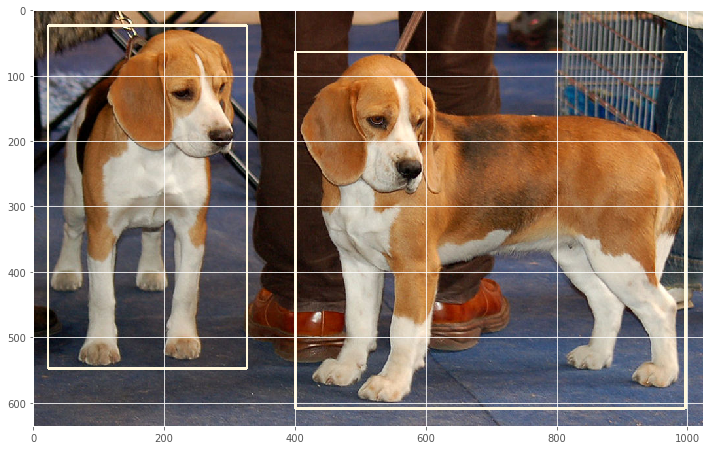

In [7]:
#Load Sample Image
image = Image.open('./assets/sample1.jpg')
image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)

with tf.Session(graph=detection_graph) as sess:
    # Actual detection.
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})
                                        
    # Remove Unecessary Dimensions (i.e [1,3,1] = [3,])
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)
    
    # Filter Bounding Boxes
    confidence_cutoff = 0.8
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)
    
    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = image.size
    box_coords = to_image_coords(boxes, height, width)
    
    # Draw Boxes
    draw_boxes(image, box_coords, classes)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(image) 
    
    

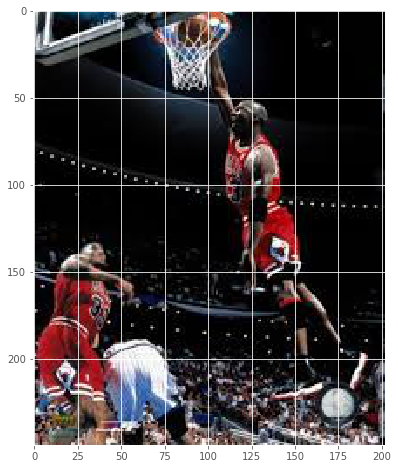

In [8]:
#Load Sample Image
image = Image.open('./assets/sample2.png')
image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)

with tf.Session(graph=detection_graph) as sess:
    # Actual detection.
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})
                                        
    # Remove Unecessary Dimensions (i.e [1,3,1] = [3,])
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)
    
    # Filter Bounding Boxes
    confidence_cutoff = 0.8
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)
    
    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = image.size
    box_coords = to_image_coords(boxes, height, width)
    
    # Draw Boxes
    draw_boxes(image, box_coords, classes)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(image) 
    

## Timing Detection

The model zoo comes with a variety of models, each its benefits and costs. Below you'll time some of these models. The general tradeoff being sacrificing model accuracy for seconds per frame (SPF).

In [9]:
def time_detection(sess, img_height, img_width, runs=10):
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')
    
    # Warmup 
    gen_image = np.uint8(np.random.randn(1, img_height, img_width, 3))
    sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: gen_image})
    
    #Record Time
    times = np.zeros(runs)
    for i in range(runs):
        t0 = time.time()
        sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: image_np})
        t1 = time.time()
        times[i] = (t1 - t0) * 1000
    return times

In [10]:
with tf.Session(graph=detection_graph) as sess:
    times = time_detection(sess, 600, 1000, runs=10)

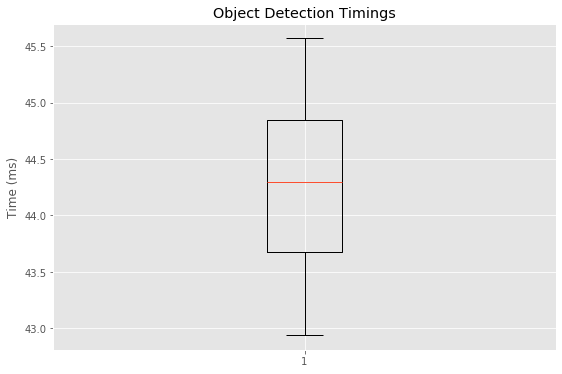

In [11]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
plt.title("Object Detection Timings")
plt.ylabel("Time (ms)")

# Create the boxplot
plt.style.use('fivethirtyeight')
bp = ax.boxplot(times)


Download a few models from the [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) and compare the timings.

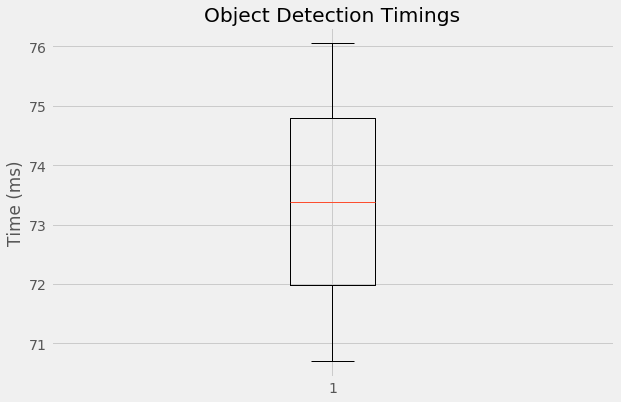

In [12]:
SSD_MOBILENET_V2 = 'assets/ssd_mobilenet_v2_oid_v4_2018_12_12/frozen_inference_graph.pb'
SSD_MOBILENET_V2 = load_graph(SSD_MOBILENET_V2)

with tf.Session(graph=SSD_MOBILENET_V2) as sess:
    times = time_detection(sess, 600, 1000, runs=10)
    
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
plt.title("Object Detection Timings")
plt.ylabel("Time (ms)")

# Create the boxplot
plt.style.use('fivethirtyeight')
bp = ax.boxplot(times)

# Detection On a Video

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('driving.mp4'))

In [15]:
clip = VideoFileClip('driving.mp4')

In [16]:
# TODO: Complete this function.
# The input is an NumPy array.
# The output should also be a NumPy array.

def pipeline(img):
    draw_img = Image.fromarray(img)
    boxes, scores, classes = sess.run([detection_boxes, detection_scores, detection_classes], 
                                      feed_dict={image_tensor: np.expand_dims(img, 0)})
    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

    confidence_cutoff = 0.8
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = draw_img.size
    box_coords = to_image_coords(boxes, height, width)

    # Each class with be represented by a differently colored box
    draw_boxes(draw_img, box_coords, classes)
    return np.array(draw_img)

In [17]:
# Run Pipleline on video
with tf.Session(graph=detection_graph) as sess:
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')
    
    new_clip = clip.fl_image(pipeline)
    
    # write to file
    new_clip.write_videofile('result.mp4')

chunk:   7%|▋         | 98/1311 [00:00<00:01, 971.24it/s, now=None]

Moviepy - Building video result.mp4.
MoviePy - Writing audio in resultTEMP_MPY_wvf_snd.mp3


t:   0%|          | 3/1782 [00:00<01:14, 23.78it/s, now=None]         

MoviePy - Done.
Moviepy - Writing video result.mp4



Moviepy - Done !
Moviepy - video ready result.mp4


In [18]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('result.mp4'))